# Image recognition android application project
- Flower image classification with Resnet (20200823)  
- 4685 training set with 5 class, 50 iterations, 32 batch

### Reference
- [coding-practice by **osterburg**], 'https://github.com/osterburg/coding-practice'

## 1. Import Packages

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import tarfile
import glob
from six.moves import urllib
from glob import glob
import random
import shutil

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
# import matplotlib
import matplotlib.pyplot as plt

## 2. Load and Explore the Flower Dataset

In [3]:
def load_data_files(base_dir):
    folder_name = "dataset/flower_photos"
    RAW_DATASET = os.path.join(base_dir, folder_name)

    abs_dir = os.path.join(os.getcwd(), folder_name)
    sub_dir = os.listdir(abs_dir)
    data_dic = {}
    
    for class_name  in sub_dir:
        imgs = glob(os.path.join(RAW_DATASET,class_name,"*.jpg"))

        data_dic[class_name] = imgs
        print("Class: {}".format(class_name))
        print("# of images: {} \n".format(len(imgs)))

    return data_dic

In [4]:
BASE_DIR = os.getcwd()
data_dic = load_data_files(BASE_DIR)

Class: daisy
# of images: 1020 

Class: dandelion
# of images: 1277 

Class: roses
# of images: 1124 

Class: sunflowers
# of images: 1158 

Class: tulips
# of images: 1275 



## 3. Split train and validation dataset

In [5]:
# Create new directory and copy files to it
def copy_files_to_directory(files, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created directory: {}".format(directory))

    for f in files:
        shutil.copy(f, directory)
    print("Copied {} files.\n".format(len(files)))

In [6]:
def train_validation_split(base_dir, data_dic, split_ratio=0.2):
    FLOWER_DATASET = os.path.join(base_dir,"flower_dataset")

    if not os.path.exists(FLOWER_DATASET):
        os.makedirs(FLOWER_DATASET)

    for class_name, imgs in data_dic.items():
        idx_split = int(len(imgs) * split_ratio)
        random.shuffle(imgs)
        validation = imgs[:idx_split]
        train = imgs[idx_split:]

        copy_files_to_directory(train, os.path.join(FLOWER_DATASET,"train",class_name))
        copy_files_to_directory(validation, os.path.join(FLOWER_DATASET,"validation",class_name))

In [ ]:
# BASE_DIR = os.getcwd()

# train_validation_split(BASE_DIR, data_dic, split_ratio=0.2)

## 4. Image preprocessing

In [46]:
batch_size = 32
num_classes = 5
epochs = 50

In [47]:
preprocessing_image = tf.keras.preprocessing.image

train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [48]:
BASE_DIR = os.getcwd()

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/train"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/validation"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

Found 4685 images belonging to 5 classes.
Found 1169 images belonging to 5 classes.


## 5. Resnet (Deep Residual Neural Network)
- Pre-activation Bottleneck Residual Block

In [49]:
models = tf.keras.models
layers = tf.keras.layers
initializers = tf.keras.initializers
regularizers = tf.keras.regularizers
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics

In [50]:
def residual_block(input_tensor, filters, stage, reg=0.0, use_shortcuts=True):

    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'merge' + str(stage)

    # 1x1 conv
    # batchnorm-relu-conv
    # from input_filters to bottleneck_filters
    
    if stage>1: # first activation is just after conv1
        x = layers.BatchNormalization(name=bn_name+'a')(input_tensor)
        x = layers.Activation('relu', name=relu_name+'a')(x)
    else:
        x = input_tensor

    x = layers.Convolution2D(
            filters[0], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name=conv_name+'a'
        )(x)

    # 3x3 conv
    # batchnorm-relu-conv
    # from bottleneck_filters to bottleneck_filters
    
    x = layers.BatchNormalization(name=bn_name+'b')(x)
    x = layers.Activation('relu', name=relu_name+'b')(x)
    x = layers.Convolution2D(
            filters[1], (3,3),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias = False,
            name=conv_name+'b'
        )(x)

    # 1x1 conv
    # batchnorm-relu-conv
    # from bottleneck_filters  to input_filters
    
    x = layers.BatchNormalization(name=bn_name+'c')(x)
    x = layers.Activation('relu', name=relu_name+'c')(x)
    x = layers.Convolution2D(
            filters[2], (1,1),
            kernel_regularizer=regularizers.l2(reg),
            name=conv_name+'c'
        )(x)

    # merge output with input layer (residual connection)
    
    if use_shortcuts:
        x = layers.add([x, input_tensor], name=merge_name)

    return x

- Full Residual Network

In [51]:
def ResNetPreAct(input_shape=(32,32,3), nb_classes=5, num_stages=5,
                 use_final_conv=False, reg=0.0):


    # Input
    img_input = layers.Input(shape=input_shape)

    #### Input stream ####
    # conv-BN-relu-(pool)
    
    x = layers.Convolution2D(
            128, (3,3), strides=(2, 2),
            padding='same',
            kernel_regularizer=regularizers.l2(reg),
            use_bias=False,
            name='conv0'
        )(img_input)
    x = layers.BatchNormalization(name='bn0')(x)
    x = layers.Activation('relu', name='relu0')(x)
#     x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool0')(x)

    #### Residual Blocks ####
    # 1x1 conv: batchnorm-relu-conv
    # 3x3 conv: batchnorm-relu-conv
    # 1x1 conv: batchnorm-relu-conv
    
    for stage in range(1,num_stages+1):
        x = residual_block(x, [32,32,128], stage=stage, reg=reg)


    #### Output stream ####
    # BN-relu-(conv)-avgPool-softmax
    
    x = layers.BatchNormalization(name='bnF')(x)
    x = layers.Activation('relu', name='reluF')(x)

    # Optional final conv layer
    if use_final_conv:
        x = layers.Convolution2D(
                64, (3,3),
                padding='same',
                kernel_regularizer=regularizers.l2(reg),
                name='convF'
            )(x)

    pool_size = input_shape[0] / 2
    x = layers.AveragePooling2D((pool_size,pool_size),name='avg_pool')(x)

    x = layers.Flatten(name='flat')(x)
    x = layers.Dense(nb_classes, activation='softmax', name='fc10')(x)

    return models.Model(img_input, x, name='rnpa')

- Architecture

In [52]:
model = ResNetPreAct()
model.summary()

Model: "rnpa"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 128)  3456        input_11[0][0]                   
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 16, 16, 128)  512         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, 16, 16, 128)  0           bn0[0][0]                        
_______________________________________________________________________________________________

- Training

In [53]:
def compile_model(model):

    loss = losses.categorical_crossentropy

    optimizer = optimizers.Adam(lr=0.0001)

    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]

    model.compile(optimizer, loss, metric)

    return model

In [54]:
model = ResNetPreAct(input_shape=(32, 32, 3), nb_classes=num_classes, num_stages=5,
                     use_final_conv=False, reg=0.005)

model = compile_model(model)

In [55]:
%%time
hist50 = model.fit_generator(
    train_generator,
    steps_per_epoch = 4685//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/50
146/146 [==============================] - 51s 348ms/step - loss: 4.6938 - categorical_accuracy: 0.4159 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.7253 - val_categorical_accuracy: 0.2031 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/50
146/146 [==============================] - 45s 309ms/step - loss: 4.1470 - categorical_accuracy: 0.5525 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.5412 - val_categorical_accuracy: 0.2031 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/50
146/146 [==============================] - 45s 311ms/step - loss: 3.7945 - categorical_accuracy: 0.5807 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.1154 - val_categorical_accuracy: 0.2781 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/50
146/146 [==============================] - 46s 312ms/step - loss: 3.5077 - categorical_accuracy: 0.6052 - top_k_categorical_accuracy: 1.0000 - val_loss: 3.4799 - val_categorical_accuracy: 0.5484 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/50
1

Epoch 22/50
146/146 [==============================] - 44s 300ms/step - loss: 1.6985 - categorical_accuracy: 0.7438 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.8011 - val_categorical_accuracy: 0.7031 - val_top_k_categorical_accuracy: 1.0000
Epoch 23/50
146/146 [==============================] - 44s 302ms/step - loss: 1.6657 - categorical_accuracy: 0.7460 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.8354 - val_categorical_accuracy: 0.6469 - val_top_k_categorical_accuracy: 1.0000
Epoch 24/50
146/146 [==============================] - 44s 303ms/step - loss: 1.6293 - categorical_accuracy: 0.7556 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.9158 - val_categorical_accuracy: 0.6469 - val_top_k_categorical_accuracy: 1.0000
Epoch 25/50
146/146 [==============================] - 44s 300ms/step - loss: 1.5979 - categorical_accuracy: 0.7554 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.6914 - val_categorical_accuracy: 0.7172 - val_top_k_categorical_accuracy: 1.0000
Epoch 26

Epoch 43/50
146/146 [==============================] - 46s 315ms/step - loss: 1.2502 - categorical_accuracy: 0.7997 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.5536 - val_categorical_accuracy: 0.7188 - val_top_k_categorical_accuracy: 1.0000
Epoch 44/50
146/146 [==============================] - 46s 316ms/step - loss: 1.2375 - categorical_accuracy: 0.7984 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.4031 - val_categorical_accuracy: 0.7406 - val_top_k_categorical_accuracy: 1.0000
Epoch 45/50
146/146 [==============================] - 47s 319ms/step - loss: 1.2261 - categorical_accuracy: 0.8007 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.7663 - val_categorical_accuracy: 0.6500 - val_top_k_categorical_accuracy: 1.0000
Epoch 46/50
146/146 [==============================] - 46s 312ms/step - loss: 1.2098 - categorical_accuracy: 0.8062 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.4650 - val_categorical_accuracy: 0.7312 - val_top_k_categorical_accuracy: 1.0000
Epoch 47

## 6. Accuracy and Loss Analysis

In [56]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

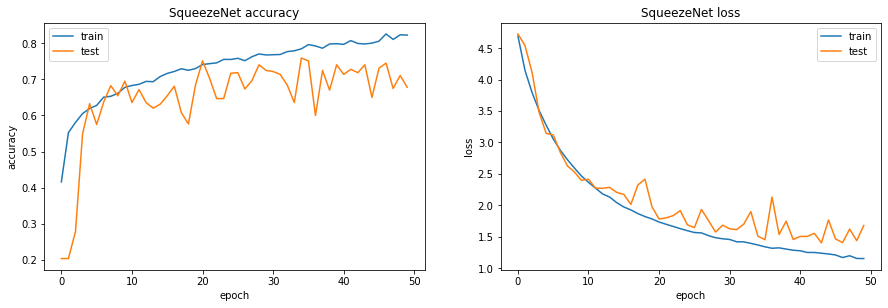

In [57]:
plot_accuracy_and_loss(hist50)

In [58]:
print("-- Evaluate --")

scores_train = model.evaluate_generator(
            train_generator, 
            steps = 5)
scores_val = model.evaluate_generator(
            validation_generator, 
            steps = 5)

print("Train %s: %.2f%%" %(model.metrics_names[1], scores_train[1]*100))
print("Val %s: %.2f%%" %(model.metrics_names[1], scores_val[1]*100))

print("-- Predict --")
output_train = model.predict_generator(train_generator, steps=5)
output_val = model.predict_generator(validation_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(train_generator.class_indices)
print(output_train)

print(validation_generator.class_indices)
print(output_val)

-- Evaluate --
Train categorical_accuracy: 79.37%
Val categorical_accuracy: 65.62%
-- Predict --
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[[0.001 0.000 0.988 0.000 0.011]
 [0.004 0.000 0.000 0.000 0.995]
 [0.022 0.000 0.976 0.000 0.002]
 [0.036 0.000 0.856 0.002 0.106]
 [0.000 0.000 0.000 1.000 0.000]
 [0.099 0.480 0.310 0.042 0.069]
 [0.006 0.002 0.201 0.522 0.269]
 [0.000 0.000 0.000 1.000 0.000]
 [0.005 0.003 0.003 0.987 0.002]
 [0.001 0.000 0.000 0.977 0.022]
 [0.000 0.000 0.000 1.000 0.000]
 [0.026 0.023 0.862 0.007 0.082]
 [0.874 0.003 0.043 0.006 0.073]
 [0.000 0.000 0.000 1.000 0.000]
 [0.114 0.827 0.042 0.004 0.013]
 [0.033 0.003 0.083 0.034 0.847]
 [0.058 0.009 0.717 0.018 0.199]
 [0.080 0.017 0.610 0.060 0.233]
 [0.010 0.002 0.028 0.007 0.953]
 [0.955 0.000 0.004 0.005 0.036]
 [0.030 0.065 0.022 0.851 0.031]
 [0.002 0.005 0.001 0.988 0.004]
 [0.214 0.016 0.373 0.197 0.199]
 [0.783 0.000 0.012 0.002 0.203]
 [0.002 0.000 0.996 0.000 0.002]
 [1.000

## 7. Save weights and model architecture

In [59]:
# save model architecture
model_json = model.to_json()
open('4_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('4_weights.h5', overwrite=True)

In [61]:
# Load trained model
import tensorflow as tf
from tensorflow.keras.models import model_from_json 
from tensorflow.keras.models import load_model

json_file = open("4_model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("4_weights.h5")
print("Loaded model from disk")

Loaded model from disk
